## FAKE NEWS DETECTION


## Import Libraries


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Upload File


In [41]:
# Upload your files to Colab or load from path
df = pd.read_csv('/content/fake.csv')
df = pd.read_csv('/content/true.csv')

# Add labels
fake['label'] = 0  # Fake
true['label'] = 1  # Real

# Combine into one DataFrame
data = pd.concat([fake, true], axis=0).reset_index(drop=True)

# Keep necessary columns
data = data[['title', 'text', 'label']]


#Handling Missing values

##Check for missing values

In [42]:

print("Missing Values:\n", data.isnull().sum())

Missing Values:
 title    0
text     0
label    0
dtype: int64


## Drop rows with nulls

In [43]:
data.dropna(subset=['text'], inplace=True)

In [44]:
# Reset index after drop
data.reset_index(drop=True, inplace=True)

#Data Overview

In [45]:
df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [46]:
df.tail()

,title,text,subject,date
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017"


In [47]:
df.shape

(21417, 4)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [49]:
df.describe()

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


In [50]:
df.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [51]:
df.isnull().sum()

,0
title,0
text,0
subject,0
date,0


In [52]:
df.duplicated().sum()

np.int64(206)

In [53]:
df.memory_usage()

,0
Index,132
title,171336
text,171336
subject,171336
date,171336


In [54]:
df.dtypes

,0
title,object
text,object
subject,object
date,object


# Feature Engineering

In [55]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

data['clean_text'] = data['text'].apply(clean_text)


In [56]:
df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


# EDA (Exploratory Data Analysis)


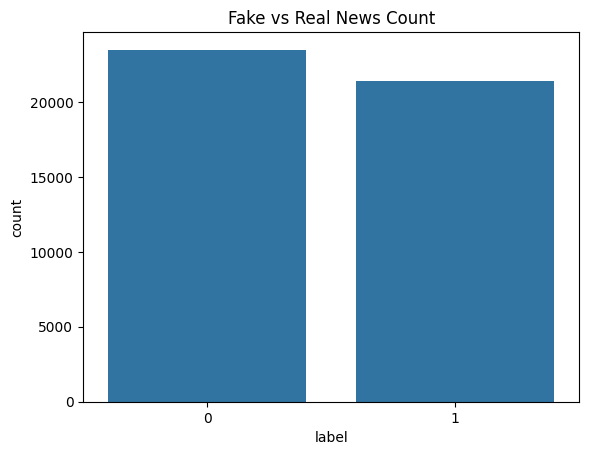

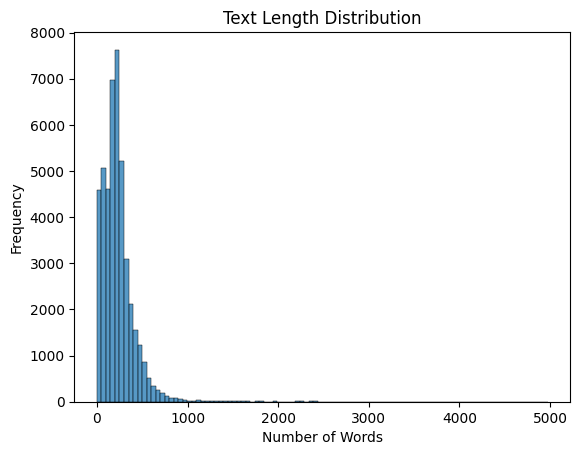

In [57]:
# Label distribution
sns.countplot(x='label', data=data)
plt.title("Fake vs Real News Count")
plt.show()

# Text length distribution
data['text_len'] = data['clean_text'].apply(lambda x: len(x.split()))
sns.histplot(data['text_len'], bins=100)
plt.title("Text Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()



# Model Training

In [58]:
X = data['clean_text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [59]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)


# Model Building(Logistic Regression)

In [60]:
model = LogisticRegression()
model.fit(X_train_vec, y_train)

# Predictions
y_pred = model.predict(X_test_vec)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.987305122494432

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      4696
           1       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



# Confusion Matrix

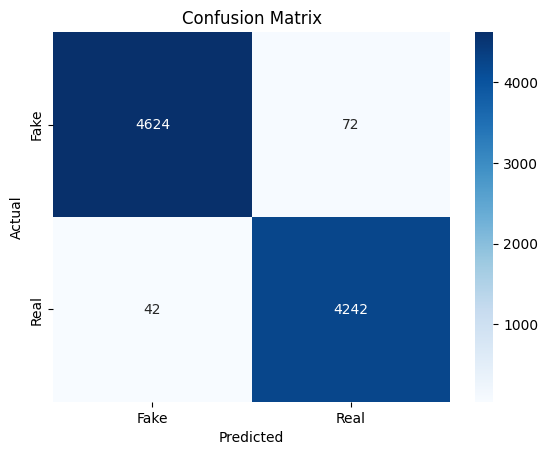

In [61]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Pikle File creation

In [62]:
import pickle

with open("fake_news_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)
